# Main Results

## Load and Process Data

In [1]:
import os
from dotenv import load_dotenv
from tabpfn_time_series.experimental.visualization.data_processing import load_wandb_runs

load_dotenv()

raw_df = load_wandb_runs(
    entity=os.getenv("WANDB_ENTITY"),
    project=os.getenv("WANDB_PROJECT_FEATURE_ABLATION"),
    tags=["main"],
)


Fetching runs from W&B...
Found 97 runs in 11.61 seconds
Extracting basic run info...


Extracting run info: 100%|██████████| 97/97 [00:00<00:00, 127899.24it/s]


Done extracting run info for 97 runs in 0.00 seconds


Processing runs: 100%|██████████| 97/97 [00:00<00:00, 268192.15it/s]


In [2]:
df = raw_df.copy()


In [3]:
from tabpfn_time_series.experimental.visualization.data_processing import (
    rename_config_names
)

config_rename_dict = {
    "second-minute-paper-auto-seasonal-linear-pad-2-ex0": "TabPFN-TS",
}

df = rename_config_names(df, config_rename_dict)

## Import External Results

In [4]:
import pandas as pd
from tabpfn_time_series.experimental.visualization.data_processing import (
    load_external_results,
    get_common_subset
)

# Load external results
external_df = load_external_results()

# Combine with main DataFrame
df = pd.concat([df, external_df])
df = get_common_subset(df)


Number of datasets with all configurations completed: 97

Configurations per dataset:
config_name
Auto_Arima            97
Auto_Theta            97
DeepAR                97
PatchTST              97
Seasonal_Naive        97
TFT                   97
TabPFN-TS             97
chronos-bolt-small    97
chronos-bolt-tiny     97
chronos_bolt_base     97
timesfm_2_0_500m      97
dtype: int64


In [5]:
drop_models = [
    "TTM-R2-Zeroshot",
    "TTM-R2-Finetuned",
]

df = df[~df["config_name"].isin(drop_models)]

## Metrics

In [6]:
from tabpfn_time_series.experimental.visualization.metrics import (
    normalize_metric_by_baseline,
    gmean_and_ci,
    amean_and_ci,
    compute_ranking,
)

# Calculate rankings
rankings = compute_ranking(df, metric_column='wSQL_mean')

# Normalize metrics
normalized_mase_df = normalize_metric_by_baseline(df, metric='MASE_0.5', baseline_model='Seasonal_Naive')
normalized_wql_df = normalize_metric_by_baseline(df, metric='wSQL_mean', baseline_model='Seasonal_Naive')

# Calculate geometric means and confidence intervals
norm_wql_mean_and_ci = normalized_wql_df.groupby('config_name').apply(lambda x: gmean_and_ci(x['wSQL_mean']))
norm_mase_mean_and_ci = normalized_mase_df.groupby('config_name').apply(lambda x: gmean_and_ci(x['MASE_0.5']))
ranking_mean_and_ci = rankings.groupby('config_name').apply(lambda x: amean_and_ci(x['rank']))


In [7]:
order_by_rank = ranking_mean_and_ci.sort_values('mean').index.tolist()
order_by_rank

['TabPFN-TS',
 'timesfm_2_0_500m',
 'chronos_bolt_base',
 'chronos-bolt-small',
 'PatchTST',
 'chronos-bolt-tiny',
 'TFT',
 'DeepAR',
 'Auto_Arima',
 'Auto_Theta',
 'Seasonal_Naive']

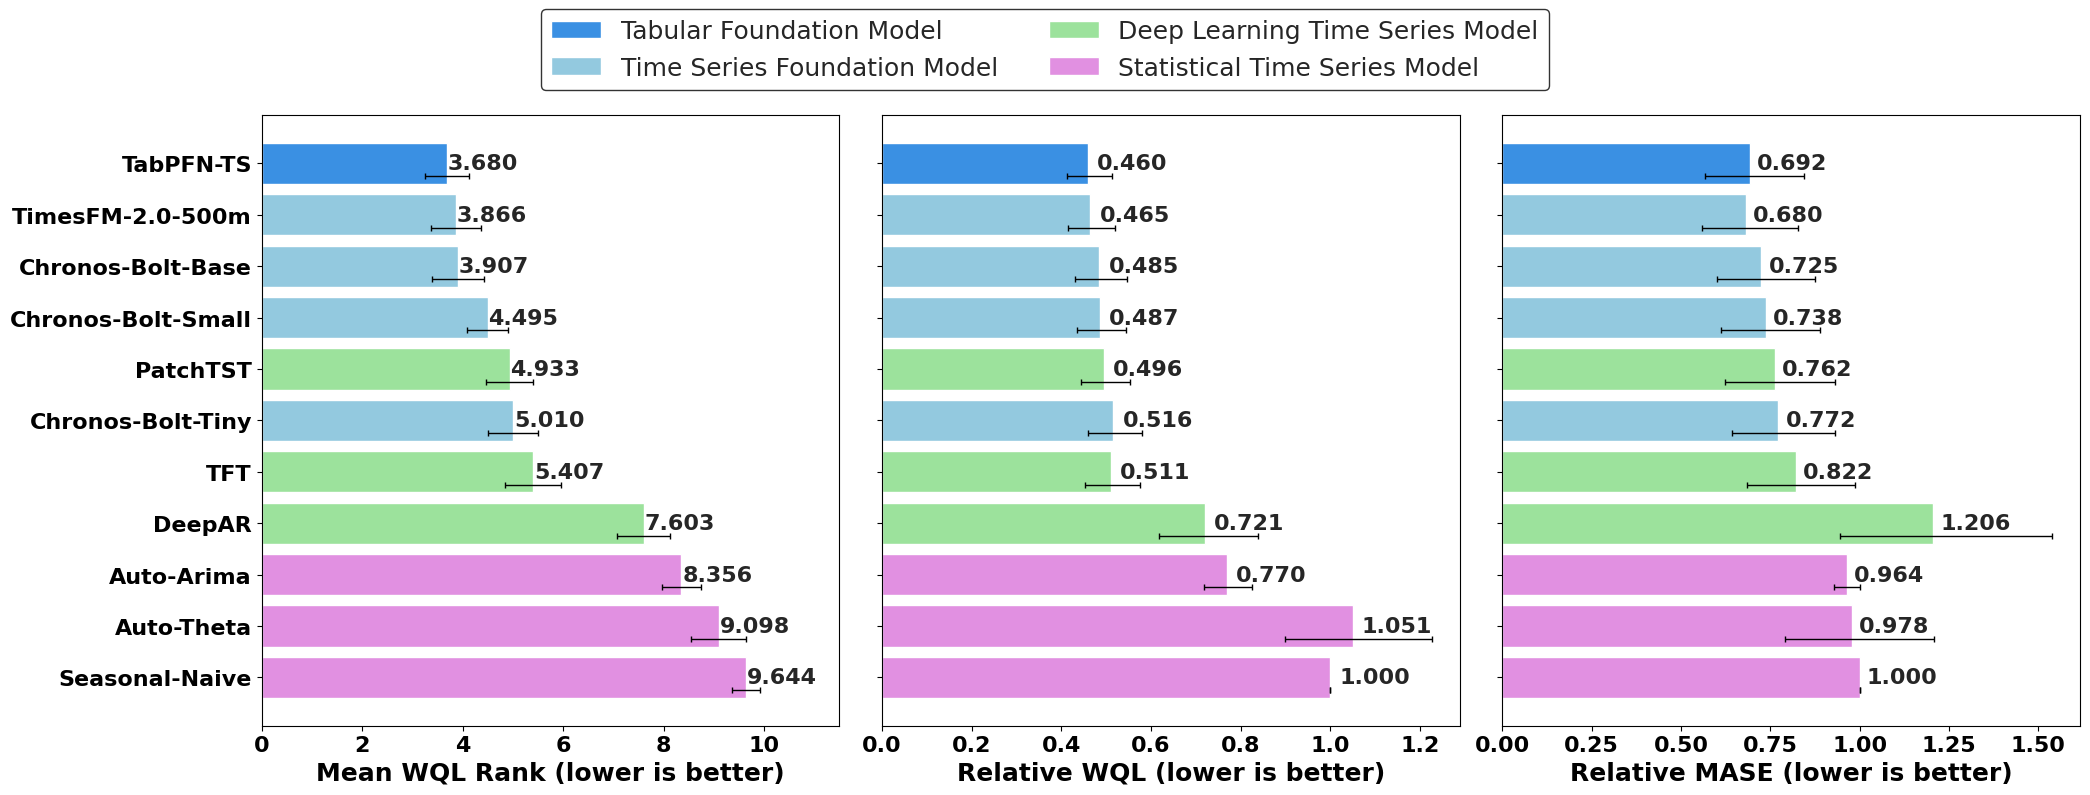

In [8]:
import matplotlib.pyplot as plt
from tabpfn_time_series.experimental.visualization.plotting import (
    plot_metric_comparison_with_model_metadata,
    save_plot_to_pdf,
)

fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)

# Plot first two subplots without legend
plot_metric_comparison_with_model_metadata(
    data=ranking_mean_and_ci,
    xaxis_label="Mean WQL Rank (lower is better)",
    ax=axes[0],
    order=order_by_rank,
    show_legend=False,
    xlim=(0, 11.5),
)

plot_metric_comparison_with_model_metadata(
    data=norm_wql_mean_and_ci,
    xaxis_label="Relative WQL (lower is better)", 
    ax=axes[1],
    order=order_by_rank,
    show_legend=False,
)

# Plot last subplot and get legend handles
ax, (handles, labels) = plot_metric_comparison_with_model_metadata(
    data=norm_mase_mean_and_ci,
    xaxis_label="Relative MASE (lower is better)",
    ax=axes[2],
    order=order_by_rank,
    show_legend=False,
)

# Add a single legend to the figure
fig.legend(handles, labels,
          bbox_to_anchor=(0.5, 1.13),
          loc='upper center',
          fontsize=18,
          borderaxespad=0,
          ncol=2,
          edgecolor='black'
)

plt.tight_layout()
save_plot_to_pdf(fig, "main_result.pdf")

In [9]:
# Plot normalized MASE grouped by dataset to visualize model performance on individual datasets
plt.figure(figsize=(16, 10))

# Get unique datasets and configs
datasets = normalized_mase_df['dataset_full_name'].unique()

# Filter for only the models we're interested in and define their order
selected_models = ['TabPFN-TS', 'timesfm_2_0_500m', 'chronos_bolt_base', 'PatchTST', 'Auto_Arima', 'Auto_Theta']
filtered_df = normalized_mase_df[normalized_mase_df['config_name'].isin(selected_models)]

# Create a categorical type with our desired order
filtered_df['config_name'] = pd.Categorical(
    filtered_df['config_name'], 
    categories=selected_models, 
    ordered=True
)

# Create a figure with vertical bars clustered by dataset
plt.figure(figsize=(100, 12))

# Use HLS color palette with only the number of colors we need
palette = sns.color_palette("hls", len(selected_models))

# Create a grouped bar chart with thicker bars and more distance between clusters
ax = sns.barplot(
    x='dataset_full_name', 
    y='MASE_0.5', 
    hue='config_name', 
    data=filtered_df,
    palette=palette,
    width=0.8,  # Slightly reduce bar width to allow more space between clusters
    dodge=0.8,  # Increase space between bars in the same cluster
    hue_order=selected_models  # Ensure the order matches our selected_models list
)

# Set y-axis limit to 3
plt.ylim(0, 3)

# Customize the plot
plt.title('Normalized MASE by Dataset (lower is better)', fontsize=16, fontweight='bold')
plt.xlabel('Dataset', fontsize=14, fontweight='bold')
plt.ylabel('Normalized MASE', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at y=1 (baseline performance)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Seasonal Naive Baseline')

# Adjust legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('normalized_mase_by_dataset_clustered.pdf', bbox_inches='tight')
plt.show()

# Calculate and display summary statistics by dataset and model, filtered for selected models
print("Summary of normalized MASE by dataset and model:")
dataset_model_stats = filtered_df.pivot_table(
    index='dataset_full_name', 
    columns='config_name', 
    values='MASE_0.5',
    aggfunc='mean'
)

# Reorder columns to match selected_models
dataset_model_stats = dataset_model_stats[selected_models]

display(dataset_model_stats)

/tmp/ipykernel_1282866/2194879545.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['config_name'] = pd.Categorical(


NameError: name 'sns' is not defined

<Figure size 1600x1000 with 0 Axes>

<Figure size 10000x1200 with 0 Axes>